# Implementation of a DQN on the PacMan Game with Keras

In [92]:
import numpy as np
import gym
from collections import deque, Counter
# deque is a double-ended queue. It can be used to remove elements both ends
import random
from datetime import datetime
import keras
from keras.layers import Conv2D, Flatten, Dense
from keras.models import Sequential
%matplotlib inline
import matplotlib.pyplot as plt

## <a id="everything"></a>Reminder about what we learned on Deep-Q networks

<br>
<div class="alert-success">
<ul>
<li> Deep Q-Learning is Q-learning with a Deep Neural Network as function approximator for $Q$.
<li> Deep Q-Network (DQN): take $s$ as input and output a Q-value per action.
<li> State space for visual tasks (like Atari game): stack the last $m$ frames in the state, $s = (im_0,\ldots,im_m)$.
<li> Experience replay: store a memory of the $N$ last samples and pick a minibatch of $n$ samples for the DQN parameters update at each time step.
</ul>
</div>

## <a id="dqnetworks"></a>Deep Q-networks

Let's define a Convolutional Neural Network (CNN) that will predict our Q-values. When we choose a greedy action, we need to evaluate $Q(s,a)$ for all possible $a$. So in our case, that means propagating $(s,a)$ values 9 times through our network. It would be more efficient to build a network that predicts the values of the 9 actions in a single pass for a given state $s$. So we define the input of our Q-network as the state only, and the output as the 9-dimensional vector evaluating each action.


Then, our network has the following structure:
- input: $84\times 84\times 4$ image (the last 4 frames)
- layer 1: Convolutions with 16 filters of size $8\times 8$ and stride 4. The activation is a ReLU function.
- layer 2: Convolutions with 32 filters of size $4\times 4$ and stride 2. The activation is a ReLU function.
- layer 3: Fully connected with 256 ReLU units
- layer 4 (output): Fully connected with 4 linear units (one for each action's value)

Graphically, this yields the following network structure.
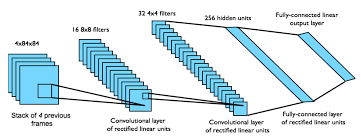

We refer to this type of CNN as *Deep Q-Networks*.

## <a id="xpr"></a>Experience replay

It is known that learning directly from consecutive samples is inefficient. The main reason is that these samples are strongly correlated with each other and learning sample by sample has the same risk of *catastrophic forgetting* that we already saw in Deep Learning. In other words, we risk forgetting about what was learned previously in some region of the state-action space, if we flood the Q-network with too many samples from another region.

In Deep Learning, this limitation was overcome by the introduction of mini-batches. Experience replay in Reinforcement Learning is a very similar approach that stores samples $(s,a,r,s')$ in a so-called *replay memory* $\mathcal{D}$ for $N$ time steps. Then, when updating the network's parameters, a mini-batch of $\mathcal{D}$ is uniformly sampled in order to compute the gradient.

Experience replay has three main advantages:
- Each sample $(s,a,r,s')$ can be reused in many updates (although this is not a N-step update, it allows a better usage of samples).
- Randomizing the mini-batch over the replay memory breaks the correlations between samples and thus reduces the variance of weights updates.
- The bias in exploration due to overestimating some Q-values (because of a tendency of neural networks to focus on the last samples) is reduced. Thus exploration is more efficient and we have less risk of getting stuck in local minima of the loss function.

<a href="#xp-replay" data-toggle="collapse"> Remarks</a><br>
<div id="xp-replay" class="collapse">
<ul>
<li> Our replay memory has finite length, we can still forget old samples. We have made our algorithm more robust but, yes, we still face catastrophic forgetting. For more refined approaches at remembering long term experience, see the usage of Recurrent Neural Networks in <a href="https://arxiv.org/pdf/1507.06527.pdf">this paper</a> for instance.
<li> The choice of uniform sampling within the replay memory is somehow a bit naive. We have seen in previous classes that the ordering of Bellman backups (in the model-based case) or TD updates (in the model-free case) have an importance in the convergence speed of the algorithm. Therefore, it would be beneficial to use a non-uniform distribution over samples in our experience replay procedure. This was developped in the <a href="https://arxiv.org/pdf/1511.05952.pdf">Prioritized Experience Replay</a> algorithm. That uses the TD error to approximate the Bellman residual and define update priorities.
<li> Experience replay *requires* an off-policy algorithm (thus it is not compatible with SARSA).
</ul>
</div>

### Reminder: the DQN algo
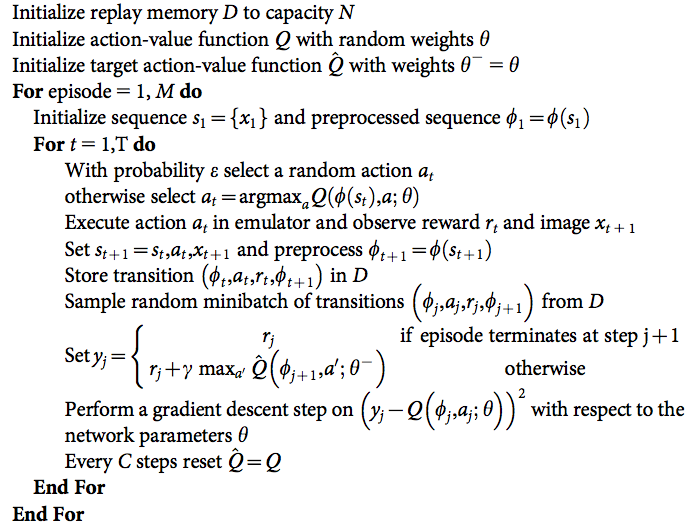

Here is the OpenAI gym link for the PacMan environment: https://gym.openai.com/envs/MsPacman-v0/

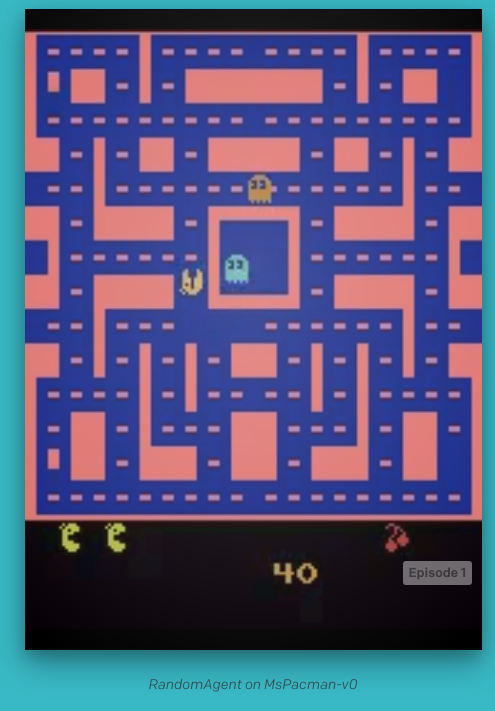

### Building the PacMan environment

In [87]:
env=gym.make("MsPacman-v0")
n_outputs=env.action_space.n
n_outputs

[2019-08-29 17:15:08,470] Making new env: MsPacman-v0


9

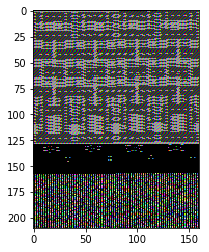

In [96]:
obs=env.reset()
plt.imshow(state)
plt.show()

### Looking at the State Space

In [88]:
print(env.observation_space)
print(env.observation_space.shape)
print(np.min(env.observation_space.low))
print(np.max(env.observation_space.high))
print(env.action_space)

Box(210, 160, 3)
(210, 160, 3)
0.0
255.0
Discrete(9)


One frame is a $210\times 160$ RGB image with a 256 color palette, so the set of all possible frames has size $256^{210 \times 160 \times 3} \sim 10^{242579}$. That's a little too many for an efficient enumeration. Even by converting the image to greyscale, downsampling to a $110\times 84$ and then cropping to a $84\times 84$ image to keep only the playing area (as we shall do a little later to slightly simplify the problem), that's still around $10^{16980}$ possible stages. So, definitely, this discrete problem is not suitable for complete enumeration.
That is why we use a neural network as a function approximation for estimating the value function.

### Preprocessing the input game screen

In [23]:
color=np.array([210, 164,74]).mean()

In [101]:
# CHANGE THE FUNCTION + ADD THE 4 stacked frames like in E.Rachelson 
def preprocess_observation(obs):
    # Crop and resize the image
    img=obs[1:176:2,::2]
    # convert the image to greyscale
    img=img.mean(axis=2)
    # Improve image contrast
    img[img==color]=0
    # normalizing the image from -1 to +1
    img=(img-128)/128 -1
    return img.reshape(80,88,1)

### Building the Q_network

In [25]:
input_shape=(80,88,1)
def deep_Q_network(input_shape, name):
    dqn=Sequential(name=name)
    dqn.add(Conv2D(32,kernel_size=(8,8), strides=4,input_shape=input_shape,activation='relu'))
    dqn.add(Conv2D(64,kernel_size=(3,3), strides=1, activation='relu'))
    dqn.add(Flatten())
    dqn.add(Dense(128,activation='relu'))
    dqn.add(Dense(n_outputs, activation='linear'))
    weights=dqn.get_weights()
    return dqn, weights

In [26]:
# parameters
epsilon=0.5
eps_min=0.05
eps_max=1.0
eps_decay_steps=500000

### Epsilon-greedy policy

In [ ]:
def epsilon_greedy(action, step):
    epsilon=max(eps_min, eps_max- (eps_max-eps_min)*step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        return action

### Building the replay buffer

In [28]:
def sample_memories(exp_buffer,batch_size):
    perm_batch=np.random.permutation(len(exp_buffer))[:batch_size]
    # do a random permutation of integers from 0 to len(exp_buffer) and then takes a sample of length batch_size
    mem=np.array(exp_buffer)[perm_batch]
    # each experience has 5 parameters: observation, action, next_observation, reward, done
    return mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4] 

### Function for reward clipping

In [82]:
def clip_reward(r):
    rr=0
    if r>0:
        rr=1
    if r<0:
        rr=-1
    return rr

In [77]:
# defining all the hyperparameters
num_episodes=250
batch_size=48
learning_rate=0.001
discount_factor=0.97
exp_buffer=[]

# counter of transitions (steps)
global_step=0
# number of steps before starting to train the network
start_steps=100
# number of steps before updating the target network
copy_steps=5
 # number of steps between each training epoch 
steps_train=4 
logdir='logs'

# optimisation hyperparameters
optimizer=keras.optimizers.Adam()
training_loss=keras.losses.mse

In [78]:
# Building the main Q network and the target network
mainDQN, mainDQN_weights=deep_Q_network(input_shape, 'mainDQN')
targetDQN, targetDQN_weights=deep_Q_network(input_shape, 'targetDQN')

### Steps to implement the DQN algorithm

* Loop over the number of episodes
* Begin the episode by resetting the state & setting the episodic reward & loss to zero
* While the state is not terminal do:
* Feed the preprocessed current state to the mainQ network and take the argmax to get the greedy action. 
* Plug this action in the epsilon to select your current action
* Do a transition with the function env.step(action): 
    append this transition (state, action, next state, reward, done) to the replay buffer (pre_process the next states and clip the rewards)
* If the global step > start_step & global step modulo steps_train=0 do: 
    * sample of mini batch of transitions with the function sample_memories()
    * Reformat the states and next_states variables to have numpy arrays 
    * Compute the training targets (TD updates): $t=reward+\gamma*\max \limits{a' \in A} (s', a')*(1-done)$
    * Compute the predicted values of Q using the mainQ network, and update the prediction with the trainig fargets for the actions sampled
    * Train the MainQ network with the mse loss, by using the function 'model.compile' and 'model.fit'of keras
    https://www.tensorflow.org/beta/guide/keras/training_and_evaluation
* If the global_step modulo the copy_step=0, update the weights of the target network
* Pursue to the next transition by assigning the current state to the next state
* Add +1 to the global step
* update the episodic reward by adding the mean reward of the mini-batch of transitions

### Launching the DQN